In [1]:
pip install scikeras

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

from scikeras.wrappers import KerasRegressor

2023-12-19 01:08:46.941705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
path = './Files/After_Feature_Engineering/Split/'

In [4]:
def label_encoder(Y_train, Y_test):
    """
    Encode categorical labels using LabelEncoder and convert them to one-hot encoding.

    Parameters:
        Y_train (pandas.DataFrame): Training labels.
        Y_test (pandas.DataFrame): Testing labels.

    Returns:
        Tuple of encoded and one-hot encoded labels for nail spacing, number of sheathing panels,
        number of end studs, as well as the original Y_train and Y_test.
    """
    # Encode and one-hot encode 'Nail spacing [cm]'
    label_encoder_nail_spacing = LabelEncoder()
    Y_train['Nail spacing [cm]'] = label_encoder_nail_spacing.fit_transform(Y_train['Nail spacing [cm]'])
    Y_test['Nail spacing [cm]'] = label_encoder_nail_spacing.transform(Y_test['Nail spacing [cm]'])
    Y_train_onehot_nail_spacing = to_categorical(Y_train['Nail spacing [cm]'], num_classes=3)
    Y_test_onehot_nail_spacing = to_categorical(Y_test['Nail spacing [cm]'], num_classes=3)

    # Encode and one-hot encode 'Number sheathing panels'
    label_encoder_num_sheathing_panels = LabelEncoder()
    Y_train['Number sheathing panels'] = label_encoder_num_sheathing_panels.fit_transform(Y_train['Number sheathing panels'])
    Y_test['Number sheathing panels'] = label_encoder_num_sheathing_panels.transform(Y_test['Number sheathing panels'])
    Y_train_onehot_num_sheathing_panels = to_categorical(Y_train['Number sheathing panels'], num_classes=2)
    Y_test_onehot_num_sheathing_panels = to_categorical(Y_test['Number sheathing panels'], num_classes=2)

    # Encode and one-hot encode 'Number end studs'
    label_encoder_num_end_studs = LabelEncoder()
    Y_train['Number end studs'] = label_encoder_num_end_studs.fit_transform(Y_train['Number end studs'])
    Y_test['Number end studs'] = label_encoder_num_end_studs.transform(Y_test['Number end studs'])
    Y_train_onehot_num_end_studs = to_categorical(Y_train['Number end studs'], num_classes=6)
    Y_test_onehot_num_end_studs = to_categorical(Y_test['Number end studs'], num_classes=6)

    # Return the results
    return (
        Y_train_onehot_nail_spacing, Y_test_onehot_nail_spacing,
        Y_train_onehot_num_sheathing_panels, Y_test_onehot_num_sheathing_panels,
        Y_train_onehot_num_end_studs, Y_test_onehot_num_end_studs,
        Y_train, Y_test
    )


def plot_loss(history):
    """
    Plot training and validation loss over epochs.
    Uses logarithmic scale for the x-axis for better visualization.

    Parameters:
        history (keras.callbacks.History): The training history obtained from model training.

    Returns:
        None
    """
    plt.figure(figsize=(15, 6))

    # Plot training loss
    plt.subplot(1, 2, 1)
    for output in history.history.keys():
        if output.endswith('loss') and not output.startswith('val_') and output != 'loss':
            plt.plot(history.history[output], label=output)

    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.xscale('log')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation loss
    plt.subplot(1, 2, 2)
    for output in history.history.keys():
        if output.startswith('val_') and output.endswith('loss') and output != 'val_loss':
            plt.plot(history.history[output], label=output[4:])

    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.xscale('log')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [5]:
X_train_C_1 = pd.read_csv(path + "X_train_C_part1_FE.csv", low_memory=False)
X_test_C_1 = pd.read_csv(path + "X_test_C_part1_FE.csv", low_memory=False)

Y_train_C_1 = pd.read_csv(path + "Y_train_C_part1_FE.csv", low_memory=False)
Y_test_C_1 = pd.read_csv(path + "Y_test_C_part1_FE.csv", low_memory=False)

In [6]:
# One hot encoding Y
Y_train_onehot_nail_spacing, Y_test_onehot_nail_spacing, Y_train_onehot_num_sheathing_panels, Y_test_onehot_num_sheathing_panels, Y_train_onehot_num_end_studs, Y_test_onehot_num_end_studs, Y_train_C_1, Y_test_C_1 = label_encoder(Y_train_C_1, Y_test_C_1)

Epoch 1/10
1557/1557 [==============================] - 8s 3ms/step - loss: 37.7269 - nail_spacing_loss: 0.8161 - num_sheathing_panels_loss: 0.3916 - num_end_studs_loss: 0.8132 - total_num_studs_loss: 24.1682 - holddown/ats_loss: 11.5378 - nail_spacing_accuracy: 0.6548 - num_sheathing_panels_accuracy: 0.8231 - num_end_studs_accuracy: 0.6951 - total_num_studs_mae: 3.4318 - holddown/ats_mae: 2.2672 - val_loss: 5.8931 - val_nail_spacing_loss: 0.6321 - val_num_sheathing_panels_loss: 0.2665 - val_num_end_studs_loss: 0.4400 - val_total_num_studs_loss: 1.7889 - val_holddown/ats_loss: 2.7656 - val_nail_spacing_accuracy: 0.7355 - val_num_sheathing_panels_accuracy: 0.8884 - val_num_end_studs_accuracy: 0.8304 - val_total_num_studs_mae: 0.8954 - val_holddown/ats_mae: 0.9892 - lr: 0.0010
Epoch 2/10
1557/1557 [==============================] - 4s 2ms/step - loss: 12.4404 - nail_spacing_loss: 0.6785 - num_sheathing_panels_loss: 0.2941 - num_end_studs_loss: 0.5473 - total_num_studs_loss: 5.0957 - hold

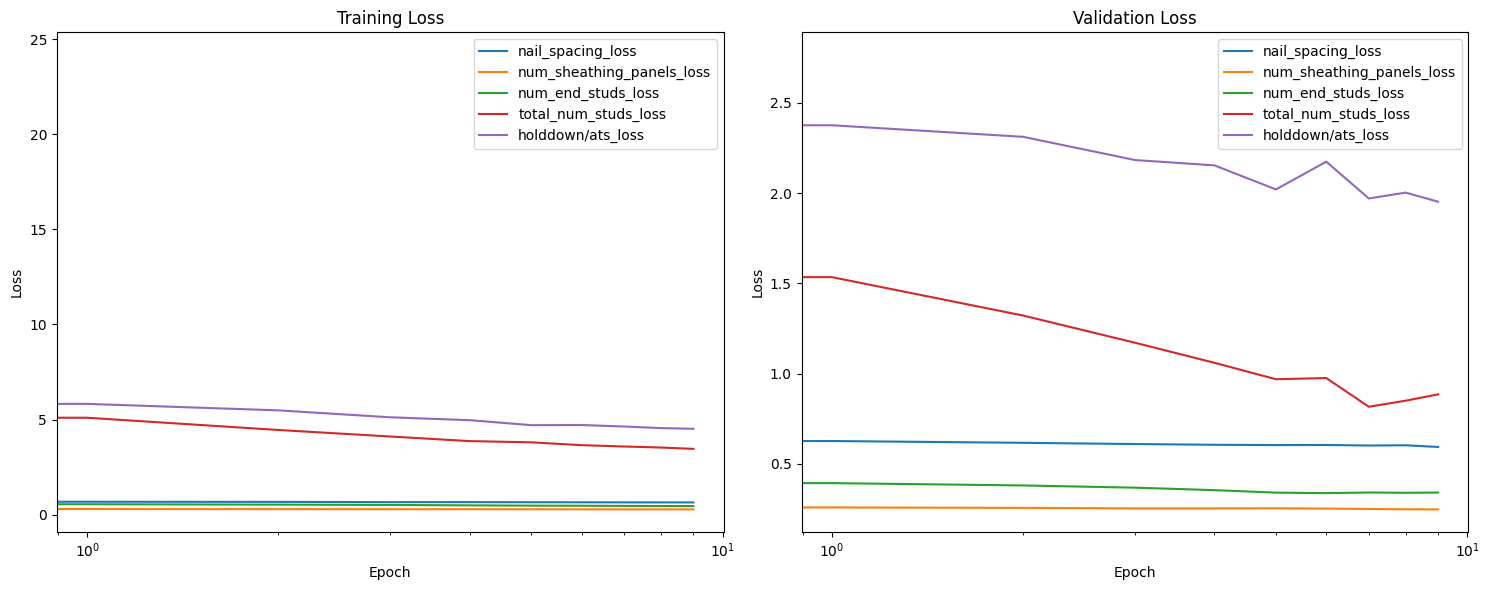

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [11]:
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from keras.utils import plot_model

def create_model(layer_sizes=[64, 32], dropout_rate=0.5):
    input_layer = Input(shape=(X_train_C_1.shape[1],))
    
    x = input_layer
    for size in layer_sizes:
        x = Dense(size, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)

    # Output layers
    nail_spacing_output = Dense(3, activation='softmax', name='nail_spacing')(x)
    num_sheathing_panels_output = Dense(2, activation='softmax', name='num_sheathing_panels')(x)
    num_end_studs_output = Dense(6, activation='softmax', name='num_end_studs')(x)
    total_num_studs_output = Dense(1, activation='linear', name='total_num_studs')(x)
    holddown_model_output = Dense(1, activation='linear', name='holddown/ats')(x)

    model = Model(inputs=input_layer, outputs=[nail_spacing_output, num_sheathing_panels_output, 
                                               num_end_studs_output, total_num_studs_output, 
                                               holddown_model_output])

    model.compile(optimizer='adam', 
                  loss={'nail_spacing': 'categorical_crossentropy',
                        'num_sheathing_panels': 'categorical_crossentropy',
                        'num_end_studs': 'categorical_crossentropy',
                        'total_num_studs': 'mean_squared_error',
                        'holddown/ats': 'mean_squared_error'},
                  metrics={'nail_spacing': 'accuracy',
                           'num_sheathing_panels': 'accuracy',
                           'num_end_studs': 'accuracy',
                           'total_num_studs': 'mae',
                           'holddown/ats': 'mae'})

    return model

# Create the model with specific parameters
model_C_1 = create_model(layer_sizes=[128, 64], dropout_rate=0.3)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)

# Train the model
history_C_1 = model_C_1.fit(
    X_train_C_1, 
    {'nail_spacing': Y_train_onehot_nail_spacing, 
     'num_sheathing_panels': Y_train_onehot_num_sheathing_panels,
     'num_end_studs': Y_train_onehot_num_end_studs,
     'total_num_studs': Y_train_C_1['Total number studs'],
     'holddown/ats': Y_train_C_1['HoldDown Model / ATS']},
    epochs=10, 
    batch_size=32, 
    validation_data=(X_test_C_1, {'nail_spacing': Y_test_onehot_nail_spacing,
                                  'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                  'num_end_studs': Y_test_onehot_num_end_studs,
                                  'total_num_studs': Y_test_C_1['Total number studs'],
                                  'holddown/ats': Y_test_C_1['HoldDown Model / ATS']}),
    callbacks=[reduce_lr]
)



plot_loss(history_C_1)

# Optionally, visualize the model structure
plot_model(model_C_1, to_file='model_C_1.png', show_shapes=True)

In [12]:
# Evaluate the model on the test set
evaluation_results = model_C_1.evaluate(X_test_C_1, {'nail_spacing': Y_test_onehot_nail_spacing, 
                                             'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                             'num_end_studs': Y_test_onehot_num_end_studs,
                                             'total_num_studs': Y_test_C_1['Total number studs'],
                                             'holddown/ats': Y_test_C_1['HoldDown Model / ATS']
                                             },
                                    batch_size=32)

# Extract and print the accuracy for each output
output_metrics = {name: value for name, value in zip(model_C_1.metrics_names, evaluation_results)}
print("Metrics on Test Set:")
for output_name, metric_value in output_metrics.items():
    print(f"{output_name}: {metric_value}")

390/390 [==============================] - 1s 1ms/step - loss: 4.0221 - nail_spacing_loss: 0.5940 - num_sheathing_panels_loss: 0.2481 - num_end_studs_loss: 0.3416 - total_num_studs_loss: 0.8855 - holddown/ats_loss: 1.9529 - nail_spacing_accuracy: 0.7483 - num_sheathing_panels_accuracy: 0.8905 - num_end_studs_accuracy: 0.8641 - total_num_studs_mae: 0.6529 - holddown/ats_mae: 0.7942
Metrics on Test Set:
loss: 4.022105693817139
nail_spacing_loss: 0.5940413475036621
num_sheathing_panels_loss: 0.24806250631809235
num_end_studs_loss: 0.341557115316391
total_num_studs_loss: 0.8855481147766113
holddown/ats_loss: 1.9528963565826416
nail_spacing_accuracy: 0.748333752155304
num_sheathing_panels_accuracy: 0.8905484676361084
num_end_studs_accuracy: 0.8641291260719299
total_num_studs_mae: 0.6529072523117065
holddown/ats_mae: 0.7942308187484741


In [7]:
import kerastuner as kt
from tensorflow import keras
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.models import Model

def build_model(hp):
    input_layer = Input(shape=(X_train_C_1.shape[1],))
    x = input_layer

    # Tune the number of layers and their sizes
    for i in range(hp.Int('num_layers', 1, 3)):
        x = Dense(units=hp.Int('units_' + str(i),
                               min_value=32,
                               max_value=128,
                               step=32),
                  activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(rate=hp.Float('dropout_' + str(i),
                                  min_value=0.0,
                                  max_value=0.3,
                                  step=0.1))(x)

    # Output layers
    nail_spacing_output = Dense(3, activation='softmax', name='nail_spacing')(x)
    num_sheathing_panels_output = Dense(2, activation='softmax', name='num_sheathing_panels')(x)
    num_end_studs_output = Dense(6, activation='softmax', name='num_end_studs')(x)
    total_num_studs_output = Dense(1, activation='linear', name='total_num_studs')(x)
    holddown_model_output = Dense(1, activation='linear', name='holddown/ats')(x)

    model = Model(inputs=input_layer, outputs=[nail_spacing_output, num_sheathing_panels_output, 
                                               num_end_studs_output, total_num_studs_output, 
                                               holddown_model_output])

    model.compile(optimizer=keras.optimizers.Adam(
                  hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss={'nail_spacing': 'categorical_crossentropy',
                        'num_sheathing_panels': 'categorical_crossentropy',
                        'num_end_studs': 'categorical_crossentropy',
                        'total_num_studs': 'mean_squared_error',
                        'holddown/ats': 'mean_squared_error'},
                  metrics={'nail_spacing': 'accuracy',
                           'num_sheathing_panels': 'accuracy',
                           'num_end_studs': 'accuracy',
                           'total_num_studs': 'mae',
                           'holddown/ats': 'mae'})

    return model

# Create a tuner instance with adjusted parameters
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=10,
                     factor=5,
                     directory='my_dir',
                     project_name='multi_output_tuning_reduced')

# Start the hyperparameter search
tuner.search(X_train_C_1, {'nail_spacing': Y_train_onehot_nail_spacing, 
                           'num_sheathing_panels': Y_train_onehot_num_sheathing_panels,
                           'num_end_studs': Y_train_onehot_num_end_studs,
                           'total_num_studs': Y_train_C_1['Total number studs'],
                           'holddown/ats': Y_train_C_1['HoldDown Model / ATS']},
             epochs=10,
             validation_data=(X_test_C_1, {'nail_spacing': Y_test_onehot_nail_spacing,
                                          'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                          'num_end_studs': Y_test_onehot_num_end_studs,
                                          'total_num_studs': Y_test_C_1['Total number studs'],
                                          'holddown/ats': Y_test_C_1['HoldDown Model / ATS']}))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from my_dir/multi_output_tuning_reduced/tuner0.json


/var/folders/wb/mz3kpqv55ksb706w7v7bvg200000gn/T/ipykernel_59774/3556563755.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


390/390 [==============================] - 2s 2ms/step - loss: 4.0545 - nail_spacing_loss: 0.5485 - num_sheathing_panels_loss: 0.2216 - num_end_studs_loss: 0.3157 - total_num_studs_loss: 1.0046 - holddown/ats_loss: 1.9640 - nail_spacing_accuracy: 0.7657 - num_sheathing_panels_accuracy: 0.8986 - num_end_studs_accuracy: 0.8657 - total_num_studs_mae: 0.6675 - holddown/ats_mae: 0.7796
Evaluation result on Test Data: [4.054487705230713, 0.5485073924064636, 0.22163502871990204, 0.3156846761703491, 1.0046323537826538, 1.9640284776687622, 0.7656789422035217, 0.8985786437988281, 0.8656548857688904, 0.6674612760543823, 0.7795564532279968]
Epoch 1/200
1557/1557 [==============================] - 7s 3ms/step - loss: 12.7805 - nail_spacing_loss: 0.6522 - num_sheathing_panels_loss: 0.2823 - num_end_studs_loss: 0.4840 - total_num_studs_loss: 5.9671 - holddown/ats_loss: 5.3948 - nail_spacing_accuracy: 0.7195 - num_sheathing_panels_accuracy: 0.8730 - num_end_studs_accuracy: 0.8064 - total_num_studs_mae

Epoch 11/200
1557/1557 [==============================] - 5s 3ms/step - loss: 5.4073 - nail_spacing_loss: 0.5435 - num_sheathing_panels_loss: 0.2192 - num_end_studs_loss: 0.2962 - total_num_studs_loss: 1.5360 - holddown/ats_loss: 2.8124 - nail_spacing_accuracy: 0.7695 - num_sheathing_panels_accuracy: 0.8989 - num_end_studs_accuracy: 0.8780 - total_num_studs_mae: 0.9442 - holddown/ats_mae: 1.1725 - val_loss: 3.6927 - val_nail_spacing_loss: 0.5357 - val_num_sheathing_panels_loss: 0.2106 - val_num_end_studs_loss: 0.2892 - val_total_num_studs_loss: 0.8077 - val_holddown/ats_loss: 1.8496 - val_nail_spacing_accuracy: 0.7657 - val_num_sheathing_panels_accuracy: 0.9016 - val_num_end_studs_accuracy: 0.8824 - val_total_num_studs_mae: 0.6779 - val_holddown/ats_mae: 0.7492
Epoch 12/200
1557/1557 [==============================] - 3s 2ms/step - loss: 5.3451 - nail_spacing_loss: 0.5420 - num_sheathing_panels_loss: 0.2206 - num_end_studs_loss: 0.2933 - total_num_studs_loss: 1.5012 - holddown/ats_loss

Epoch 22/200
1557/1557 [==============================] - 3s 2ms/step - loss: 4.9353 - nail_spacing_loss: 0.5180 - num_sheathing_panels_loss: 0.2069 - num_end_studs_loss: 0.2607 - total_num_studs_loss: 1.3782 - holddown/ats_loss: 2.5715 - nail_spacing_accuracy: 0.7773 - num_sheathing_panels_accuracy: 0.9029 - num_end_studs_accuracy: 0.8916 - total_num_studs_mae: 0.9004 - holddown/ats_mae: 1.1277 - val_loss: 3.3715 - val_nail_spacing_loss: 0.5273 - val_num_sheathing_panels_loss: 0.2088 - val_num_end_studs_loss: 0.2538 - val_total_num_studs_loss: 0.6278 - val_holddown/ats_loss: 1.7538 - val_nail_spacing_accuracy: 0.7727 - val_num_sheathing_panels_accuracy: 0.9018 - val_num_end_studs_accuracy: 0.8945 - val_total_num_studs_mae: 0.5659 - val_holddown/ats_mae: 0.7056
Epoch 23/200
1557/1557 [==============================] - 6s 4ms/step - loss: 4.9396 - nail_spacing_loss: 0.5196 - num_sheathing_panels_loss: 0.2080 - num_end_studs_loss: 0.2568 - total_num_studs_loss: 1.3525 - holddown/ats_loss

Epoch 33/200
1557/1557 [==============================] - 3s 2ms/step - loss: 4.7810 - nail_spacing_loss: 0.5035 - num_sheathing_panels_loss: 0.2026 - num_end_studs_loss: 0.2400 - total_num_studs_loss: 1.3277 - holddown/ats_loss: 2.5073 - nail_spacing_accuracy: 0.7867 - num_sheathing_panels_accuracy: 0.9038 - num_end_studs_accuracy: 0.9006 - total_num_studs_mae: 0.8896 - holddown/ats_mae: 1.1023 - val_loss: 3.2803 - val_nail_spacing_loss: 0.4945 - val_num_sheathing_panels_loss: 0.1995 - val_num_end_studs_loss: 0.2328 - val_total_num_studs_loss: 0.5857 - val_holddown/ats_loss: 1.7678 - val_nail_spacing_accuracy: 0.7840 - val_num_sheathing_panels_accuracy: 0.9009 - val_num_end_studs_accuracy: 0.8983 - val_total_num_studs_mae: 0.5091 - val_holddown/ats_mae: 0.6710
Epoch 34/200
1557/1557 [==============================] - 6s 4ms/step - loss: 4.8262 - nail_spacing_loss: 0.5046 - num_sheathing_panels_loss: 0.2023 - num_end_studs_loss: 0.2409 - total_num_studs_loss: 1.2959 - holddown/ats_loss

Epoch 44/200
1557/1557 [==============================] - 3s 2ms/step - loss: 4.6412 - nail_spacing_loss: 0.4960 - num_sheathing_panels_loss: 0.1946 - num_end_studs_loss: 0.2299 - total_num_studs_loss: 1.2685 - holddown/ats_loss: 2.4522 - nail_spacing_accuracy: 0.7856 - num_sheathing_panels_accuracy: 0.9085 - num_end_studs_accuracy: 0.9039 - total_num_studs_mae: 0.8732 - holddown/ats_mae: 1.0990 - val_loss: 3.3382 - val_nail_spacing_loss: 0.4969 - val_num_sheathing_panels_loss: 0.1969 - val_num_end_studs_loss: 0.2286 - val_total_num_studs_loss: 0.6511 - val_holddown/ats_loss: 1.7647 - val_nail_spacing_accuracy: 0.7805 - val_num_sheathing_panels_accuracy: 0.9032 - val_num_end_studs_accuracy: 0.8966 - val_total_num_studs_mae: 0.5417 - val_holddown/ats_mae: 0.6844
Epoch 45/200
1557/1557 [==============================] - 3s 2ms/step - loss: 4.6649 - nail_spacing_loss: 0.4918 - num_sheathing_panels_loss: 0.1941 - num_end_studs_loss: 0.2306 - total_num_studs_loss: 1.2247 - holddown/ats_loss

Epoch 55/200
1557/1557 [==============================] - 4s 2ms/step - loss: 4.6376 - nail_spacing_loss: 0.4835 - num_sheathing_panels_loss: 0.1874 - num_end_studs_loss: 0.2224 - total_num_studs_loss: 1.2606 - holddown/ats_loss: 2.4837 - nail_spacing_accuracy: 0.7931 - num_sheathing_panels_accuracy: 0.9142 - num_end_studs_accuracy: 0.9075 - total_num_studs_mae: 0.8670 - holddown/ats_mae: 1.1220 - val_loss: 3.3205 - val_nail_spacing_loss: 0.4730 - val_num_sheathing_panels_loss: 0.1874 - val_num_end_studs_loss: 0.2297 - val_total_num_studs_loss: 0.5573 - val_holddown/ats_loss: 1.8730 - val_nail_spacing_accuracy: 0.7918 - val_num_sheathing_panels_accuracy: 0.9083 - val_num_end_studs_accuracy: 0.8999 - val_total_num_studs_mae: 0.5058 - val_holddown/ats_mae: 0.7342
Epoch 56/200
1557/1557 [==============================] - 4s 2ms/step - loss: 4.5691 - nail_spacing_loss: 0.4812 - num_sheathing_panels_loss: 0.1898 - num_end_studs_loss: 0.2207 - total_num_studs_loss: 1.2718 - holddown/ats_loss

Epoch 66/200
1557/1557 [==============================] - 4s 2ms/step - loss: 4.3880 - nail_spacing_loss: 0.4735 - num_sheathing_panels_loss: 0.1767 - num_end_studs_loss: 0.2143 - total_num_studs_loss: 1.1785 - holddown/ats_loss: 2.3450 - nail_spacing_accuracy: 0.8003 - num_sheathing_panels_accuracy: 0.9209 - num_end_studs_accuracy: 0.9104 - total_num_studs_mae: 0.8423 - holddown/ats_mae: 1.0839 - val_loss: 3.2054 - val_nail_spacing_loss: 0.4791 - val_num_sheathing_panels_loss: 0.2122 - val_num_end_studs_loss: 0.2167 - val_total_num_studs_loss: 0.5812 - val_holddown/ats_loss: 1.7162 - val_nail_spacing_accuracy: 0.7903 - val_num_sheathing_panels_accuracy: 0.8997 - val_num_end_studs_accuracy: 0.9011 - val_total_num_studs_mae: 0.5398 - val_holddown/ats_mae: 0.6474
Epoch 67/200
1557/1557 [==============================] - 4s 2ms/step - loss: 4.4072 - nail_spacing_loss: 0.4695 - num_sheathing_panels_loss: 0.1774 - num_end_studs_loss: 0.2126 - total_num_studs_loss: 1.1971 - holddown/ats_loss

Epoch 77/200
1557/1557 [==============================] - 4s 3ms/step - loss: 4.2650 - nail_spacing_loss: 0.4634 - num_sheathing_panels_loss: 0.1674 - num_end_studs_loss: 0.2068 - total_num_studs_loss: 1.1671 - holddown/ats_loss: 2.2604 - nail_spacing_accuracy: 0.8037 - num_sheathing_panels_accuracy: 0.9264 - num_end_studs_accuracy: 0.9134 - total_num_studs_mae: 0.8414 - holddown/ats_mae: 1.0613 - val_loss: 3.0669 - val_nail_spacing_loss: 0.4613 - val_num_sheathing_panels_loss: 0.1625 - val_num_end_studs_loss: 0.2141 - val_total_num_studs_loss: 0.5364 - val_holddown/ats_loss: 1.6926 - val_nail_spacing_accuracy: 0.8004 - val_num_sheathing_panels_accuracy: 0.9267 - val_num_end_studs_accuracy: 0.9040 - val_total_num_studs_mae: 0.4855 - val_holddown/ats_mae: 0.6687
Epoch 78/200
1557/1557 [==============================] - 4s 3ms/step - loss: 4.4058 - nail_spacing_loss: 0.4624 - num_sheathing_panels_loss: 0.1663 - num_end_studs_loss: 0.2077 - total_num_studs_loss: 1.2299 - holddown/ats_loss

Epoch 88/200
1557/1557 [==============================] - 4s 2ms/step - loss: 4.3208 - nail_spacing_loss: 0.4537 - num_sheathing_panels_loss: 0.1590 - num_end_studs_loss: 0.2018 - total_num_studs_loss: 1.2117 - holddown/ats_loss: 2.2946 - nail_spacing_accuracy: 0.8084 - num_sheathing_panels_accuracy: 0.9300 - num_end_studs_accuracy: 0.9158 - total_num_studs_mae: 0.8500 - holddown/ats_mae: 1.0809 - val_loss: 2.9948 - val_nail_spacing_loss: 0.4412 - val_num_sheathing_panels_loss: 0.1515 - val_num_end_studs_loss: 0.2154 - val_total_num_studs_loss: 0.5579 - val_holddown/ats_loss: 1.6288 - val_nail_spacing_accuracy: 0.8129 - val_num_sheathing_panels_accuracy: 0.9331 - val_num_end_studs_accuracy: 0.9044 - val_total_num_studs_mae: 0.4797 - val_holddown/ats_mae: 0.6377
Epoch 89/200
1557/1557 [==============================] - 4s 2ms/step - loss: 4.3466 - nail_spacing_loss: 0.4524 - num_sheathing_panels_loss: 0.1584 - num_end_studs_loss: 0.2018 - total_num_studs_loss: 1.2130 - holddown/ats_loss

Epoch 99/200
1557/1557 [==============================] - 4s 2ms/step - loss: 4.2636 - nail_spacing_loss: 0.4489 - num_sheathing_panels_loss: 0.1574 - num_end_studs_loss: 0.1993 - total_num_studs_loss: 1.1919 - holddown/ats_loss: 2.2662 - nail_spacing_accuracy: 0.8106 - num_sheathing_panels_accuracy: 0.9321 - num_end_studs_accuracy: 0.9181 - total_num_studs_mae: 0.8495 - holddown/ats_mae: 1.0663 - val_loss: 3.3670 - val_nail_spacing_loss: 0.4427 - val_num_sheathing_panels_loss: 0.1565 - val_num_end_studs_loss: 0.2232 - val_total_num_studs_loss: 0.7631 - val_holddown/ats_loss: 1.7815 - val_nail_spacing_accuracy: 0.8112 - val_num_sheathing_panels_accuracy: 0.9303 - val_num_end_studs_accuracy: 0.9015 - val_total_num_studs_mae: 0.6596 - val_holddown/ats_mae: 0.7449
Epoch 100/200
1557/1557 [==============================] - 4s 2ms/step - loss: 4.2521 - nail_spacing_loss: 0.4478 - num_sheathing_panels_loss: 0.1545 - num_end_studs_loss: 0.1991 - total_num_studs_loss: 1.2048 - holddown/ats_los

Epoch 110/200
1557/1557 [==============================] - 4s 2ms/step - loss: 4.1866 - nail_spacing_loss: 0.4417 - num_sheathing_panels_loss: 0.1524 - num_end_studs_loss: 0.1936 - total_num_studs_loss: 1.1801 - holddown/ats_loss: 2.2188 - nail_spacing_accuracy: 0.8133 - num_sheathing_panels_accuracy: 0.9347 - num_end_studs_accuracy: 0.9194 - total_num_studs_mae: 0.8455 - holddown/ats_mae: 1.0620 - val_loss: 3.1470 - val_nail_spacing_loss: 0.4384 - val_num_sheathing_panels_loss: 0.1625 - val_num_end_studs_loss: 0.2101 - val_total_num_studs_loss: 0.7120 - val_holddown/ats_loss: 1.6240 - val_nail_spacing_accuracy: 0.8101 - val_num_sheathing_panels_accuracy: 0.9289 - val_num_end_studs_accuracy: 0.9071 - val_total_num_studs_mae: 0.6516 - val_holddown/ats_mae: 0.6593
Epoch 111/200
1557/1557 [==============================] - 4s 2ms/step - loss: 4.1244 - nail_spacing_loss: 0.4408 - num_sheathing_panels_loss: 0.1519 - num_end_studs_loss: 0.1935 - total_num_studs_loss: 1.1431 - holddown/ats_lo

Epoch 121/200
1557/1557 [==============================] - 4s 2ms/step - loss: 4.1686 - nail_spacing_loss: 0.4365 - num_sheathing_panels_loss: 0.1457 - num_end_studs_loss: 0.1909 - total_num_studs_loss: 1.1831 - holddown/ats_loss: 2.2123 - nail_spacing_accuracy: 0.8192 - num_sheathing_panels_accuracy: 0.9373 - num_end_studs_accuracy: 0.9214 - total_num_studs_mae: 0.8432 - holddown/ats_mae: 1.0634 - val_loss: 2.9228 - val_nail_spacing_loss: 0.4209 - val_num_sheathing_panels_loss: 0.1382 - val_num_end_studs_loss: 0.2078 - val_total_num_studs_loss: 0.5859 - val_holddown/ats_loss: 1.5700 - val_nail_spacing_accuracy: 0.8208 - val_num_sheathing_panels_accuracy: 0.9370 - val_num_end_studs_accuracy: 0.9081 - val_total_num_studs_mae: 0.5597 - val_holddown/ats_mae: 0.6210
Epoch 122/200
1557/1557 [==============================] - 4s 2ms/step - loss: 4.1608 - nail_spacing_loss: 0.4383 - num_sheathing_panels_loss: 0.1476 - num_end_studs_loss: 0.1893 - total_num_studs_loss: 1.1728 - holddown/ats_lo

Epoch 132/200
1557/1557 [==============================] - 4s 2ms/step - loss: 4.1115 - nail_spacing_loss: 0.4327 - num_sheathing_panels_loss: 0.1468 - num_end_studs_loss: 0.1882 - total_num_studs_loss: 1.1498 - holddown/ats_loss: 2.1939 - nail_spacing_accuracy: 0.8181 - num_sheathing_panels_accuracy: 0.9373 - num_end_studs_accuracy: 0.9215 - total_num_studs_mae: 0.8339 - holddown/ats_mae: 1.0621 - val_loss: 2.9951 - val_nail_spacing_loss: 0.4417 - val_num_sheathing_panels_loss: 0.1579 - val_num_end_studs_loss: 0.2188 - val_total_num_studs_loss: 0.5352 - val_holddown/ats_loss: 1.6415 - val_nail_spacing_accuracy: 0.8111 - val_num_sheathing_panels_accuracy: 0.9307 - val_num_end_studs_accuracy: 0.9058 - val_total_num_studs_mae: 0.4867 - val_holddown/ats_mae: 0.6573
Epoch 133/200
1557/1557 [==============================] - 4s 2ms/step - loss: 4.1855 - nail_spacing_loss: 0.4339 - num_sheathing_panels_loss: 0.1463 - num_end_studs_loss: 0.1896 - total_num_studs_loss: 1.1770 - holddown/ats_lo

Epoch 143/200
1557/1557 [==============================] - 4s 3ms/step - loss: 4.1967 - nail_spacing_loss: 0.4324 - num_sheathing_panels_loss: 0.1443 - num_end_studs_loss: 0.1888 - total_num_studs_loss: 1.1607 - holddown/ats_loss: 2.2705 - nail_spacing_accuracy: 0.8195 - num_sheathing_panels_accuracy: 0.9385 - num_end_studs_accuracy: 0.9226 - total_num_studs_mae: 0.8387 - holddown/ats_mae: 1.0774 - val_loss: 3.0979 - val_nail_spacing_loss: 0.4387 - val_num_sheathing_panels_loss: 0.1588 - val_num_end_studs_loss: 0.2330 - val_total_num_studs_loss: 0.5735 - val_holddown/ats_loss: 1.6939 - val_nail_spacing_accuracy: 0.8127 - val_num_sheathing_panels_accuracy: 0.9295 - val_num_end_studs_accuracy: 0.9037 - val_total_num_studs_mae: 0.5240 - val_holddown/ats_mae: 0.7314
Epoch 144/200
1557/1557 [==============================] - 4s 3ms/step - loss: 4.0301 - nail_spacing_loss: 0.4288 - num_sheathing_panels_loss: 0.1451 - num_end_studs_loss: 0.1849 - total_num_studs_loss: 1.1543 - holddown/ats_lo

Epoch 154/200
1557/1557 [==============================] - 4s 2ms/step - loss: 4.0199 - nail_spacing_loss: 0.4255 - num_sheathing_panels_loss: 0.1414 - num_end_studs_loss: 0.1848 - total_num_studs_loss: 1.0894 - holddown/ats_loss: 2.1787 - nail_spacing_accuracy: 0.8202 - num_sheathing_panels_accuracy: 0.9383 - num_end_studs_accuracy: 0.9239 - total_num_studs_mae: 0.8090 - holddown/ats_mae: 1.0669 - val_loss: 3.0036 - val_nail_spacing_loss: 0.4097 - val_num_sheathing_panels_loss: 0.1425 - val_num_end_studs_loss: 0.2105 - val_total_num_studs_loss: 0.5235 - val_holddown/ats_loss: 1.7174 - val_nail_spacing_accuracy: 0.8219 - val_num_sheathing_panels_accuracy: 0.9373 - val_num_end_studs_accuracy: 0.9147 - val_total_num_studs_mae: 0.4830 - val_holddown/ats_mae: 0.7242
Epoch 155/200
1557/1557 [==============================] - 4s 2ms/step - loss: 3.9962 - nail_spacing_loss: 0.4259 - num_sheathing_panels_loss: 0.1424 - num_end_studs_loss: 0.1859 - total_num_studs_loss: 1.1206 - holddown/ats_lo

Epoch 165/200
1557/1557 [==============================] - 4s 3ms/step - loss: 3.9628 - nail_spacing_loss: 0.4255 - num_sheathing_panels_loss: 0.1394 - num_end_studs_loss: 0.1839 - total_num_studs_loss: 1.1165 - holddown/ats_loss: 2.0975 - nail_spacing_accuracy: 0.8216 - num_sheathing_panels_accuracy: 0.9407 - num_end_studs_accuracy: 0.9244 - total_num_studs_mae: 0.8209 - holddown/ats_mae: 1.0382 - val_loss: 3.3983 - val_nail_spacing_loss: 0.4391 - val_num_sheathing_panels_loss: 0.1545 - val_num_end_studs_loss: 0.2165 - val_total_num_studs_loss: 0.7348 - val_holddown/ats_loss: 1.8534 - val_nail_spacing_accuracy: 0.8144 - val_num_sheathing_panels_accuracy: 0.9364 - val_num_end_studs_accuracy: 0.9121 - val_total_num_studs_mae: 0.6719 - val_holddown/ats_mae: 0.6781
Epoch 166/200
1557/1557 [==============================] - 4s 3ms/step - loss: 4.0046 - nail_spacing_loss: 0.4253 - num_sheathing_panels_loss: 0.1397 - num_end_studs_loss: 0.1815 - total_num_studs_loss: 1.1453 - holddown/ats_lo

Epoch 176/200
1557/1557 [==============================] - 4s 2ms/step - loss: 4.0628 - nail_spacing_loss: 0.4254 - num_sheathing_panels_loss: 0.1390 - num_end_studs_loss: 0.1805 - total_num_studs_loss: 1.1542 - holddown/ats_loss: 2.1636 - nail_spacing_accuracy: 0.8233 - num_sheathing_panels_accuracy: 0.9409 - num_end_studs_accuracy: 0.9261 - total_num_studs_mae: 0.8339 - holddown/ats_mae: 1.0636 - val_loss: 2.9491 - val_nail_spacing_loss: 0.4151 - val_num_sheathing_panels_loss: 0.1404 - val_num_end_studs_loss: 0.2079 - val_total_num_studs_loss: 0.5206 - val_holddown/ats_loss: 1.6651 - val_nail_spacing_accuracy: 0.8274 - val_num_sheathing_panels_accuracy: 0.9405 - val_num_end_studs_accuracy: 0.9073 - val_total_num_studs_mae: 0.4921 - val_holddown/ats_mae: 0.6966
Epoch 177/200
1557/1557 [==============================] - 4s 2ms/step - loss: 4.0419 - nail_spacing_loss: 0.4219 - num_sheathing_panels_loss: 0.1403 - num_end_studs_loss: 0.1819 - total_num_studs_loss: 1.1561 - holddown/ats_lo

Epoch 187/200
1557/1557 [==============================] - 4s 2ms/step - loss: 4.0157 - nail_spacing_loss: 0.4227 - num_sheathing_panels_loss: 0.1368 - num_end_studs_loss: 0.1815 - total_num_studs_loss: 1.1179 - holddown/ats_loss: 2.1569 - nail_spacing_accuracy: 0.8224 - num_sheathing_panels_accuracy: 0.9416 - num_end_studs_accuracy: 0.9257 - total_num_studs_mae: 0.8245 - holddown/ats_mae: 1.0578 - val_loss: 2.9484 - val_nail_spacing_loss: 0.4181 - val_num_sheathing_panels_loss: 0.1485 - val_num_end_studs_loss: 0.2015 - val_total_num_studs_loss: 0.5580 - val_holddown/ats_loss: 1.6222 - val_nail_spacing_accuracy: 0.8218 - val_num_sheathing_panels_accuracy: 0.9377 - val_num_end_studs_accuracy: 0.9109 - val_total_num_studs_mae: 0.5047 - val_holddown/ats_mae: 0.6319
Epoch 188/200
1557/1557 [==============================] - 4s 3ms/step - loss: 3.9907 - nail_spacing_loss: 0.4186 - num_sheathing_panels_loss: 0.1376 - num_end_studs_loss: 0.1756 - total_num_studs_loss: 1.1305 - holddown/ats_lo

Epoch 198/200
1557/1557 [==============================] - 4s 3ms/step - loss: 3.9098 - nail_spacing_loss: 0.4180 - num_sheathing_panels_loss: 0.1365 - num_end_studs_loss: 0.1771 - total_num_studs_loss: 1.1150 - holddown/ats_loss: 2.0632 - nail_spacing_accuracy: 0.8255 - num_sheathing_panels_accuracy: 0.9413 - num_end_studs_accuracy: 0.9269 - total_num_studs_mae: 0.8190 - holddown/ats_mae: 1.0230 - val_loss: 3.2101 - val_nail_spacing_loss: 0.4345 - val_num_sheathing_panels_loss: 0.1525 - val_num_end_studs_loss: 0.2276 - val_total_num_studs_loss: 0.5369 - val_holddown/ats_loss: 1.8587 - val_nail_spacing_accuracy: 0.8135 - val_num_sheathing_panels_accuracy: 0.9357 - val_num_end_studs_accuracy: 0.9098 - val_total_num_studs_mae: 0.5273 - val_holddown/ats_mae: 0.6767
Epoch 199/200
1557/1557 [==============================] - 4s 2ms/step - loss: 3.9749 - nail_spacing_loss: 0.4196 - num_sheathing_panels_loss: 0.1376 - num_end_studs_loss: 0.1815 - total_num_studs_loss: 1.1488 - holddown/ats_lo

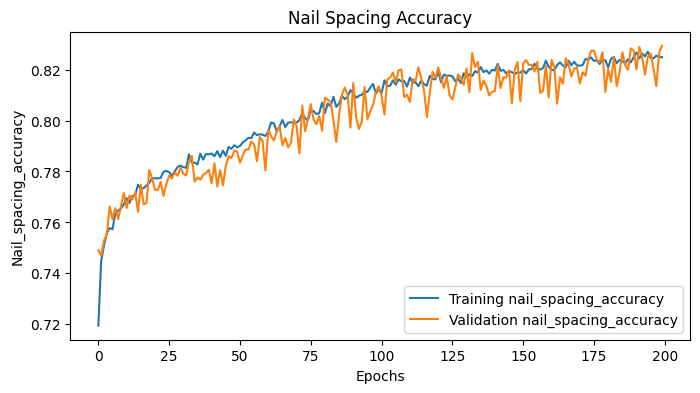

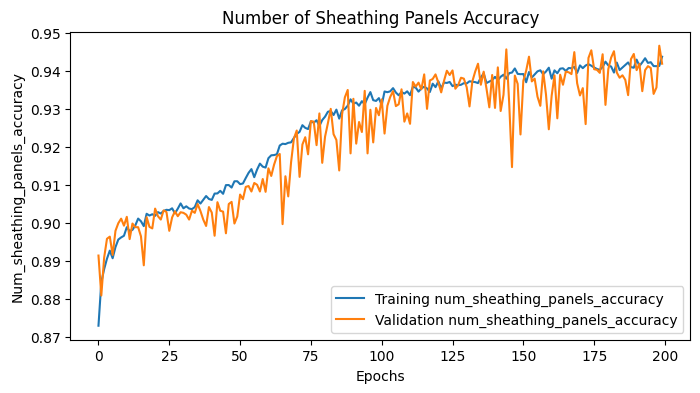

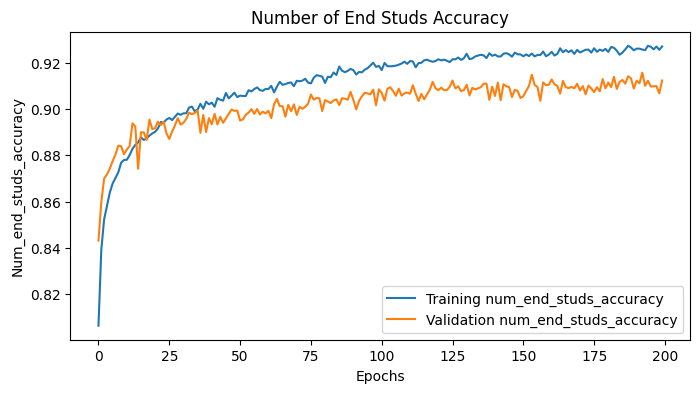

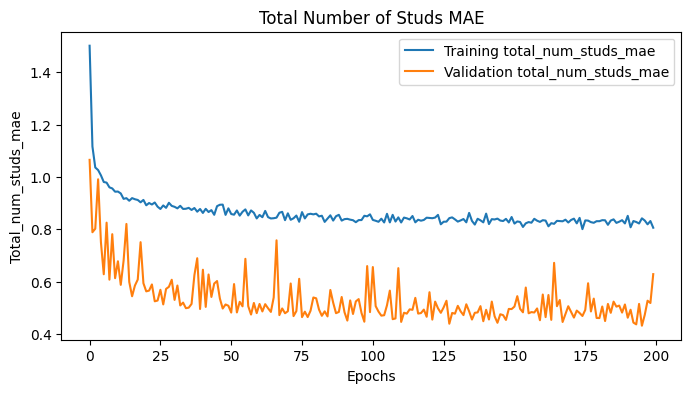

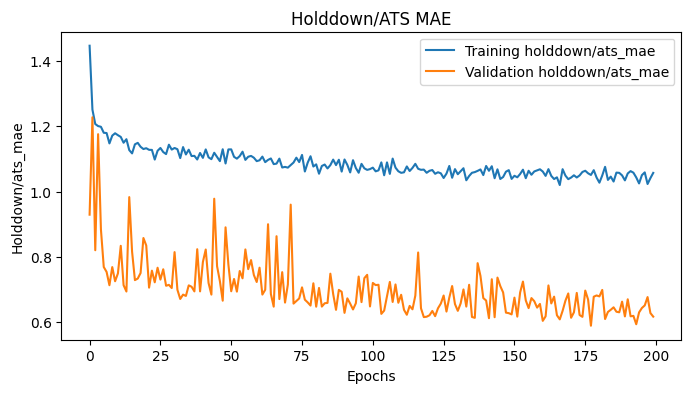

In [8]:
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on test data
eval_result = best_model.evaluate(X_test_C_1, {'nail_spacing': Y_test_onehot_nail_spacing,
                                               'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                               'num_end_studs': Y_test_onehot_num_end_studs,
                                               'total_num_studs': Y_test_C_1['Total number studs'],
                                               'holddown/ats': Y_test_C_1['HoldDown Model / ATS']})
print("Evaluation result on Test Data:", eval_result)


# Re-train the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = build_model(best_hps)
history = model.fit(X_train_C_1, {'nail_spacing': Y_train_onehot_nail_spacing, 
                                  'num_sheathing_panels': Y_train_onehot_num_sheathing_panels,
                                  'num_end_studs': Y_train_onehot_num_end_studs,
                                  'total_num_studs': Y_train_C_1['Total number studs'],
                                  'holddown/ats': Y_train_C_1['HoldDown Model / ATS']},
                    epochs=200,  # Number of epochs
                    validation_data=(X_test_C_1, {'nail_spacing': Y_test_onehot_nail_spacing,
                                                  'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                                  'num_end_studs': Y_test_onehot_num_end_studs,
                                                  'total_num_studs': Y_test_C_1['Total number studs'],
                                                  'holddown/ats': Y_test_C_1['HoldDown Model / ATS']}))

def plot_and_save_metrics(history, metric_name, title, filename):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history[metric_name], label=f'Training {metric_name}')
    plt.plot(history.history[f'val_{metric_name}'], label=f'Validation {metric_name}')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    save_dir = './Files/Visualisation/NN/'
    plt.savefig(save_dir + filename)  # Save the plot to a file
    plt.show()

# Plot and save for each output
plot_and_save_metrics(history, 'nail_spacing_accuracy', 'Nail Spacing Accuracy', 'nail_spacing_accuracy.png')
plot_and_save_metrics(history, 'num_sheathing_panels_accuracy', 'Number of Sheathing Panels Accuracy', 'num_sheathing_panels_accuracy.png')
plot_and_save_metrics(history, 'num_end_studs_accuracy', 'Number of End Studs Accuracy', 'num_end_studs_accuracy.png')
plot_and_save_metrics(history, 'total_num_studs_mae', 'Total Number of Studs MAE', 'total_num_studs_mae.png')
plot_and_save_metrics(history, 'holddown/ats_mae', 'Holddown/ATS MAE', 'holddown_ats_mae.png')

In [10]:
print("Best Hyperparameters:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")

Best Hyperparameters:
num_layers: 3
units_0: 128
dropout_0: 0.0
learning_rate: 0.006764554555654514
tuner/epochs: 5
tuner/initial_epoch: 1
tuner/bracket: 1
tuner/round: 1
units_1: 32
dropout_1: 0.0
units_2: 32
dropout_2: 0.0
tuner/trial_id: 0000
